In [61]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import math
from ngboost import NGBRegressor

## Génération des variables

In [134]:
def distribution(x) :
    µ = int(x<=0)
    sigma = 0.05
    return µ, sigma

Text(0, 0.5, 'y')

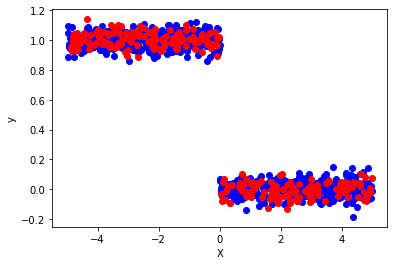

In [135]:
n_samples = 1000
X = np.random.uniform(-5,5,n_samples)[...,None]
y = np.array([[np.random.normal(*distribution(x[0]))] for x in X])

X_train, X_val, y_train, y_val = train_test_split(X,y)
y_train = y_train.T[0]
y_val =y_val.T[0]
plt.scatter(X_train,y_train,color='blue')
plt.scatter(X_val,y_val,color='red')
plt.xlabel('X')
plt.ylabel('y')

## Entraînement

In [136]:
def train_model(max_depth=3,n_estimators=500,ordinary_gradient=False,early_stopping_rounds=None) :
    tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth)

    if ordinary_gradient :
        model = NGBRegressor(Base=tree,n_estimators=n_estimators,natural_gradient=False)
    else :
        model = NGBRegressor(Base=tree,n_estimators=n_estimators)

    if early_stopping_rounds is not None :
        model.fit(X_train,y_train,
                  X_val=X_val,
                  Y_val=y_val,
                  early_stopping_rounds=early_stopping_rounds
                )
    else :
        model.fit(X_train,y_train,
                  X_val=X_val,
                  Y_val=y_val
                )
    
    return model

In [137]:
models_natural = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_natural.append(train_model(n_estimators = iterations,early_stopping_rounds= 3))
    if len(models_natural) >= 2 :
        if len(models_natural[-1].base_models) == len(models_natural[-2].base_models) :
            models_natural.pop(-1)
            break
    iterations += 50

Number of iterations : 0
Number of iterations : 50
[iter 0] loss=0.7304 val_loss=0.7303 scale=1.0000 norm=0.5093
Number of iterations : 100
[iter 0] loss=0.7304 val_loss=0.7303 scale=1.0000 norm=0.5093
Number of iterations : 150
[iter 0] loss=0.7304 val_loss=0.7303 scale=1.0000 norm=0.5093
[iter 100] loss=-0.3479 val_loss=-0.3510 scale=2.0000 norm=0.9135
Number of iterations : 200
[iter 0] loss=0.7304 val_loss=0.7303 scale=1.0000 norm=0.5093
[iter 100] loss=-0.3479 val_loss=-0.3510 scale=2.0000 norm=0.9135
Number of iterations : 250
[iter 0] loss=0.7304 val_loss=0.7303 scale=1.0000 norm=0.5093
[iter 100] loss=-0.3479 val_loss=-0.3510 scale=2.0000 norm=0.9135
[iter 200] loss=-1.2012 val_loss=-1.1841 scale=2.0000 norm=0.8411
Number of iterations : 300
[iter 0] loss=0.7304 val_loss=0.7303 scale=1.0000 norm=0.5093
[iter 100] loss=-0.3479 val_loss=-0.3510 scale=2.0000 norm=0.9135
[iter 200] loss=-1.2012 val_loss=-1.1841 scale=2.0000 norm=0.8411
Number of iterations : 350
[iter 0] loss=0.730

In [138]:
models_ordinary = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_ordinary.append(train_model(n_estimators = iterations,early_stopping_rounds= 3,ordinary_gradient=True))
    if len(models_ordinary) >= 2 :
        if len(models_ordinary[-1].base_models) == len(models_ordinary[-2].base_models) :
            models_ordinary.pop(-1)
            break
    if iterations >= 800 :
        break
    iterations += 50

Number of iterations : 0
Number of iterations : 50
[iter 0] loss=0.7304 val_loss=0.7207 scale=0.5000 norm=0.9954
Number of iterations : 100
[iter 0] loss=0.7304 val_loss=0.7207 scale=0.5000 norm=0.9954
Number of iterations : 150
[iter 0] loss=0.7304 val_loss=0.7207 scale=0.5000 norm=0.9954
[iter 100] loss=-0.1247 val_loss=-0.1280 scale=0.5000 norm=0.5372
Number of iterations : 200
[iter 0] loss=0.7304 val_loss=0.7207 scale=0.5000 norm=0.9954
[iter 100] loss=-0.1247 val_loss=-0.1280 scale=0.5000 norm=0.5372
Number of iterations : 250
[iter 0] loss=0.7304 val_loss=0.7207 scale=0.5000 norm=0.9954
[iter 100] loss=-0.1247 val_loss=-0.1280 scale=0.5000 norm=0.5372
[iter 200] loss=-0.8360 val_loss=-0.8192 scale=0.5000 norm=0.7728
Number of iterations : 300
[iter 0] loss=0.7304 val_loss=0.7207 scale=0.5000 norm=0.9954
[iter 100] loss=-0.1247 val_loss=-0.1280 scale=0.5000 norm=0.5372
[iter 200] loss=-0.8360 val_loss=-0.8192 scale=0.5000 norm=0.7728
Number of iterations : 350
[iter 0] loss=0.730

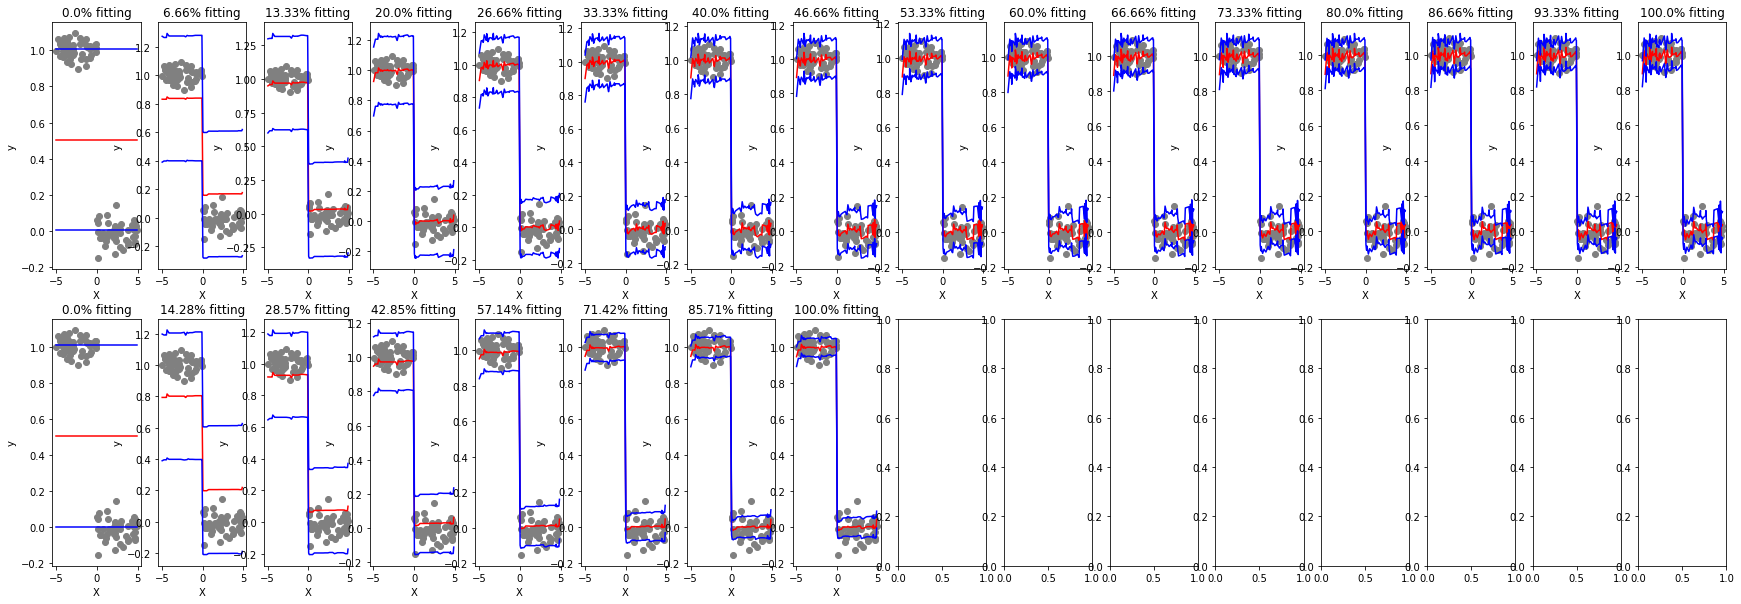

In [139]:
n_samples = 100
X = np.random.uniform(-5,5,n_samples)
X = np.sort(X)
y = np.array([[np.random.normal(*distribution(x))] for x in X])

X = X[...,None]
distribs_ordinary = [models_ordinary[i].pred_dist(X) for i in range(len(models_ordinary))]
distribs_natural = [models_natural[i].pred_dist(X) for i in range(len(models_natural))]



y_pred_ordinary = np.array([distribs.params['loc'] for distribs in distribs_ordinary])
sigma_pred_ordinary = np.array([distribs.params['scale'] for distribs in distribs_ordinary])
y1_pred_ordinary = y_pred_ordinary - sigma_pred_ordinary
y2_pred_ordinary = y_pred_ordinary + sigma_pred_ordinary

y_pred_natural = np.array([distribs.params['loc'] for distribs in distribs_natural])
sigma_pred_natural = np.array([distribs.params['scale'] for distribs in distribs_natural])
y1_pred_natural = y_pred_natural - sigma_pred_natural
y2_pred_natural = y_pred_natural + sigma_pred_natural

fig, axs = plt.subplots(2,max(len(distribs_natural), len(distribs_ordinary)),figsize = (30,10))
for i in range(len(distribs_ordinary)) :
    axs[0,i].scatter(X,y,color='grey')
    axs[0,i].plot(X,y_pred_ordinary[i],color='red')
    axs[0,i].plot(X,y1_pred_ordinary[i],color='blue')
    axs[0,i].plot(X,y2_pred_ordinary[i],color='blue')
    axs[0,i].set_xlabel('X')
    axs[0,i].set_ylabel('y')
    axs[0,i].set_title(f'{int(10000*i/(len(distribs_ordinary)-1))/100}% fitting')

for i in range(len(distribs_natural)) :
    axs[1,i].scatter(X,y,color='grey')
    axs[1,i].plot(X,y_pred_natural[i],color='red')
    axs[1,i].plot(X,y1_pred_natural[i],color='blue')
    axs[1,i].plot(X,y2_pred_natural[i],color='blue')
    axs[1,i].set_title(f'{int(10000*i/(len(distribs_natural)-1))/100}% fitting')
    axs[1,i].set_xlabel('X')
    axs[1,i].set_ylabel('y')